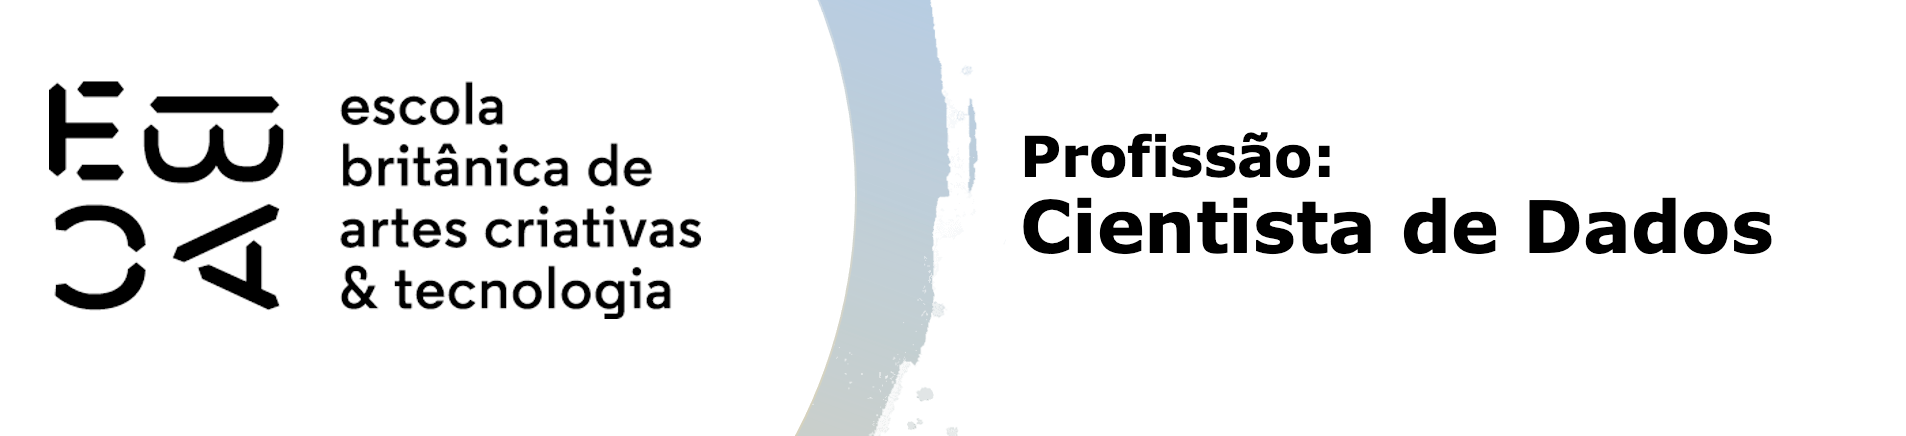

# Tarefa

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?" 

Nosso objetivo é tentar agrupar os clientes conforme seu comportamento de navegação entre páginas administrativas, informativas e de produtos. 

As variáveis estão descritas abaixo (em tradução livre do link indicado).

Por este motivo, o escopo desta análise estará fechado nas primeiras seis variáveis da tabela, referentes a quantidade e tempo de acesso por tipo de página, atributos que falam mais do comportamento de navegação do cliente que de características da página o da época do ano.

|Variavel                |Descrição          | 
|------------------------|:-------------------| 
|Administrative          | Quantidade de acessos em páginas administrativas| 
|Administrative_Duration | Tempo de acesso em páginas administrativas | 
|Informational           | Quantidade de acessos em páginas informativas  | 
|Informational_Duration  | Tempo de acesso em páginas informativas  | 
|ProductRelated          | Quantidade de acessos em páginas de produtos | 
|ProductRelated_Duration | Tempo de acesso em páginas de produtos | 
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  | 
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações | 
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico | 
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) | 
|Month                   | Mês  | 
|OperatingSystems        | Sistema operacional do visitante | 
|Browser                 | Browser do visitante | 
|Region                  | Região | 
|TrafficType             | Tipo de tráfego                  | 
|VisitorType             | Tipo de visitante: novo ou recorrente | 
|Weekend                 | Indica final de semana | 
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score
from tqdm.notebook import tqdm

In [6]:
df = pd.read_csv('online_shoppers_intention.csv')

In [7]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [8]:
df.Revenue.value_counts(dropna=False)

Revenue
False    10422
True      1908
Name: count, dtype: int64

## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

##### Vamos verificar se existem missings nesta base de dados:

In [11]:
df.isna().sum()

#Assim, vemos que não existem dados faltantes na nossa base, portanto, podemos prosseguir.

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

####  Nos interessam, para nossa classificação, as colunas "Administrative, Administrative_duration, Informational, Informational_Duration, ProductRelated e ProductRelated_Duration". Vamos isolar estas variáveis, e padronizá-las:

In [13]:
df_selected = df.iloc[:,0:6]
df_pad = pd.DataFrame(StandardScaler().fit_transform(df_selected))
df_pad.columns = df_selected.columns
df_pad.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430


## Número de grupos

Utilize as técnicas vistas em aula que te ajudem a decidir pelo número de grupos a ser utilizados.

#### Agora, utilizaremos as técnicas de silhouete e o "método do cotovelo":

In [16]:
SQD = []
K = range(1,15)
for k in tqdm(K):
    km = KMeans(n_clusters = k)
    km = km.fit(df_pad)
    SQD.append(km.inertia_)



  0%|          | 0/14 [00:00<?, ?it/s]

<Axes: xlabel='num_clusters'>

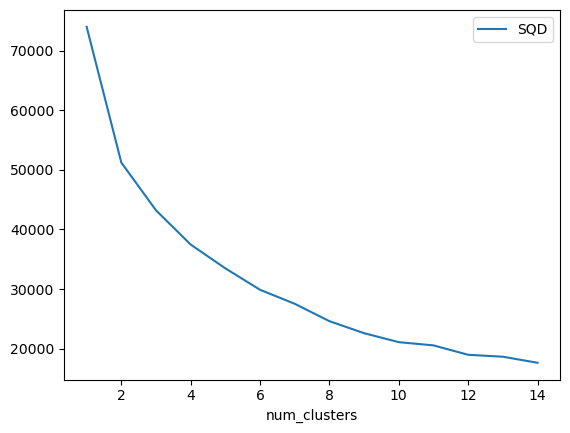

In [17]:
# Aplicando a técnica dos "cotovelos"

results = pd.DataFrame({'num_clusters': list(range(1, len(SQD) + 1)), 'SQD': SQD})
results.plot(x='num_clusters', y='SQD')


## Em primeira instância, visívelmente, apenas um cotovelo é extremamente perceptível. no num_clusters = 8 também podemos ver uma guinada... no entanto, vamos aplicar a técnica silhouete e considerar ambos para tomar uma melhor decisão.

In [19]:
df_pad.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430


In [20]:
silhuetas = []
max_clusters = 15
df_pad2 = df_pad.copy()
for n_clusters in range(2, max_clusters+1):
    km = KMeans(n_clusters=n_clusters).fit(df_pad)
    
    nomes_grupos = ['grupo_' + str(g) for g in range(n_clusters)]

    silhuetas.append(silhouette_score(df_pad, km.labels_)) 
    
    df_pad2['grupos_'+str(n_clusters)] = pd.Categorical.from_codes(km.labels_, categories=nomes_grupos)


,n_clusters,silhueta_media
0,2,0.622424
1,3,0.508982
2,4,0.505350
3,5,0.478980
4,6,0.461236


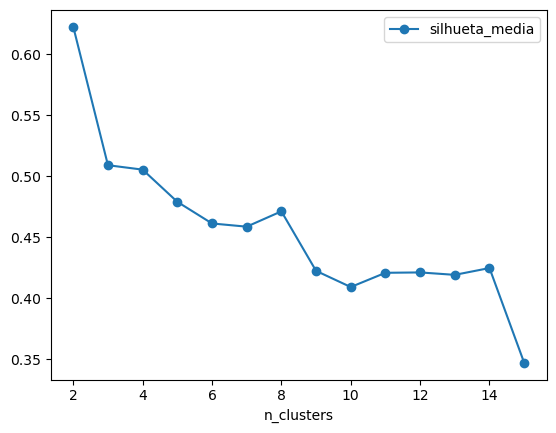

In [21]:
df_silhueta = pd.DataFrame({'n_clusters': list(range(2, max_clusters+1)), 'silhueta_media': silhuetas})

df_silhueta.plot.line(x= 'n_clusters', y='silhueta_media', marker = 'o')
df_silhueta.head()

#### O método da silhueta, portanto, confirma que o nosso melhor agrupamento é aquele que divide nossos dados em 2 clusters. Agora, portanto, devemos fazer uma análise qualitativa de quais são estes dois grupos, e que informações podemos tirar deles...

## Avaliação dos grupos

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final. 
- Se puder, sugira nomes para os grupos.

In [24]:
df_pad2.head()
df2grupos = df_pad.copy()
df2grupos['grupos_2'] = df_pad2['grupos_2']
df2grupos.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,grupos_2
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,grupo_0
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,grupo_0
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,grupo_0
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,grupo_0
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,grupo_0


In [52]:
df2grupos.groupby('grupos_2')[['Administrative','Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration']].mean()

# Com dois grupos, algo curioso acontece: a única distinção feita pelo nosso algoritmo parece ser a distinção entre usuários que usam muito a internet
# E os que usam pouco, não discernindo bem em qual tipo de sites os usuários passam mais tempo. Com isso, provavelmetne é adequado e interessante
# Aumentarmos o número de grupos, e vermos se conseguimos criar "perfis diferentes" para cada grupo.

C:\Users\Matheus\AppData\Local\Temp\ipykernel_18748\809665188.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df2grupos.groupby('grupos_2')[['Administrative','Administrative_Duration', 'Informational',


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration
grupos_2,,,,,,
grupo_0,-0.247032,-0.207952,-0.247838,-0.194928,-0.233126,-0.218679
grupo_1,1.491500,1.255548,1.496365,1.176914,1.407538,1.320312


In [25]:
df8grupos = df_pad.copy()
df8grupos['grupos_8'] = df_pad2['grupos_8']
df8grupos.head()


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,grupos_8
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,grupo_0
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,grupo_0
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,grupo_0
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,grupo_0
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,grupo_0


In [56]:
df8grupos.groupby('grupos_8')[['Administrative','Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration']].mean()

C:\Users\Matheus\AppData\Local\Temp\ipykernel_18748\4122895457.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df8grupos.groupby('grupos_8')[['Administrative','Administrative_Duration', 'Informational',


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration
grupos_8,,,,,,
grupo_0,-0.511907,-0.365166,-0.332484,-0.225672,-0.381962,-0.356158
grupo_1,1.924460,5.083183,0.491133,0.204748,0.485864,0.619279
grupo_2,1.198037,0.629556,-0.211073,-0.191496,0.003802,-0.060163
grupo_3,0.690099,0.324807,1.928954,0.707322,0.225928,0.189016
grupo_4,1.560921,2.283362,4.097901,10.146184,2.898665,4.045672
grupo_5,1.240663,0.639940,3.232398,4.040145,0.771830,0.845152
grupo_6,-0.044846,-0.150099,-0.080962,-0.123491,1.183490,1.148347
grupo_7,1.822904,0.906784,1.372517,0.537349,4.517909,4.035786


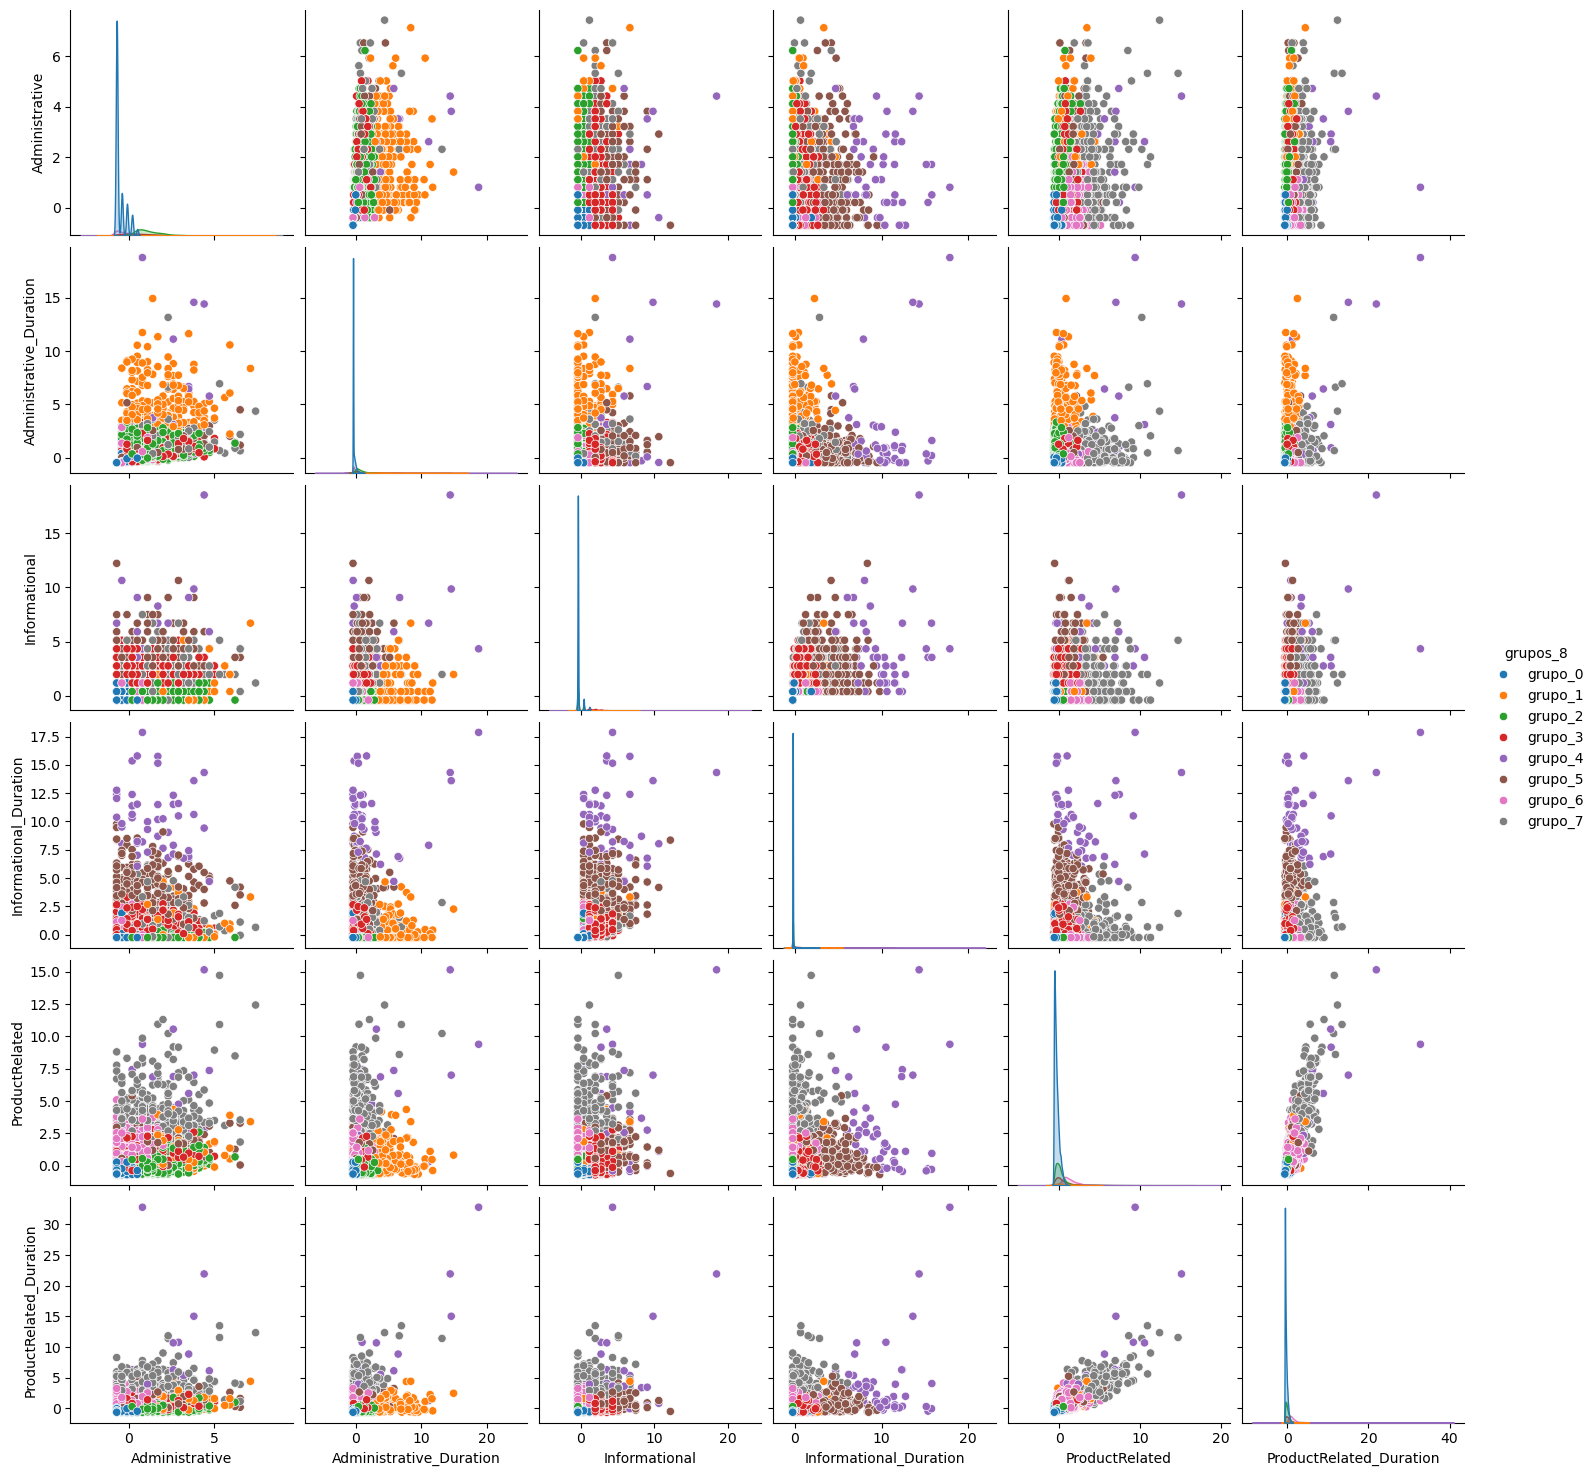

In [59]:
sns.pairplot(data = df8grupos, hue="grupos_8")

O nosso pairplot mostra que nossos dados são definitivamente distintos o bastante pra que possam ser considerados úteis. Embora eles se confundam bastante, a distinção é suficiente para que sejam dotados de valor, e mesmo as "zonas de confusão" são bem delineadas

#### Analisando, podemos ver alguns grupos interessantes... o grupo 0 parece ser de pessoas que usam pouco a internet em geral, indiscriminadamente de qual seja o tipo de site. Este grupo pode ser formado por exemplo, de pessoas idosas ou digitalmente iletradas, que só navegam na internet mediante necesside... o grupo 1 são pessoas que raramente utilizam páginas que não sejam administrativas, e utilizam páginas administrativas com muita frequências. Essas pessoas, possivelmente, estão em ambiente de trabalho, e portanto, em suas sessões, raramente acessam sites que não sejam relacionados à suas áreas de atuação e atividades diárias. O grupo 2 possui um perfil diferente, onde, quando acessam algo, são sites administrativos, mas acessam com mais frequência do que o grupo 0. Estas pessoas podem ser pessoas semelhantes as do grupo 1, mas porém que seus trabalhos não envolvem tecnologia e acesso constante à internet. O grupo 3 passa a maior parte do seu tempo em sites informacionais. Podem ser estudantes em ambiente escolar, como em sessões de chromebooks de escolas estaduais, pois suas sessões são relativamente curtas. O grupo 4 possui uma extensa carga horária em sites informacionais, intercalada com sites administrativos e relacionados à produtos, o que corresponde bastante ao perfil de um jovem adolescente simplesmente "navegando" na internet, isto se considerarmos que "Sites informacionais" aí também enquadrariam as redes sociais. O grupo 5 é um perfil bastante difícil de se especificar uma atividade, mas algo que poderia gerar um perfil parecido são pessoas que possuem afazeres não relacionados à tecnologia e o "tempo que sobra" passam navegando livremente na internet, dada a baixa duração total, e bastante diversificada. O grupo 6 provavelmente são pessoas que só usam a internet mediante necessidades de compra, por exemplo! É claro que são usuáriosque, nos raros momentos em que acessam a internet, estão acessando coisas relacionadas à produtos. Enquanto o grupo 7 possui um perfil extremamente curioso: eles passam relativamente pouco tempo total na internet, e o tempo que passam, quase que em sua totalidade, eles o passam em sites relacionados à produtos. Estas pessoas poderiam fácilmente ser "compradores compulsivos", que passam seus dias em grande parte olhando sites de lojas e ofertas como Shopee, AliExpress, Mercado livre e etc.

### Importante lembrar que todas as hipóteses levantadas são frágeis e pouco amparadas, e que um cuidado extra deveria ser tomado caso estas informações fossem ser usadas para tomar decisões importantes. Estas inferências servem de base para uma investigação posterior, mas não podem ser vistas como certas ou definitivas. Lembrando a nossa repetida frase:
## Todos os modelos estão errados, mas alguns são úteis.

## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*). 
- Qual grupo possui clientes mais propensos à compra?

In [83]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [91]:
grupo8_analise_final = pd.concat([df8grupos, df[['BounceRates', 'Revenue']]], axis=1)
groupby_final = grupo8_analise_final.groupby('grupos_8')[['BounceRates', 'Revenue']].mean()
groupby_final

C:\Users\Matheus\AppData\Local\Temp\ipykernel_18748\2922813252.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groupby_final = grupo8_analise_final.groupby('grupos_8')[['BounceRates', 'Revenue']].mean()


,BounceRates,Revenue
grupos_8,,
grupo_0,0.031101,0.114150
grupo_1,0.006445,0.221698
grupo_2,0.006503,0.197312
grupo_3,0.007798,0.232288
grupo_4,0.007267,0.270833
grupo_5,0.007443,0.279835
grupo_6,0.007231,0.223453
grupo_7,0.005291,0.348936


Bingo! Uma das afirmações, que é a de que possívelmente o oitavo grupo seria constituído das pessoas que em média mais compravam, possívelmente até mesmo compulsivas, se mostrou verdadeira, dada a média do Revenue! Estas pessoas compram 34% das vezes, um índice 7% mais alto até mesmo que o segundo lugar!